Navigating Energy Risks Case Study

C:\Users\ykkba\AppData\Local\Temp\ipykernel_25552\3241299333.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


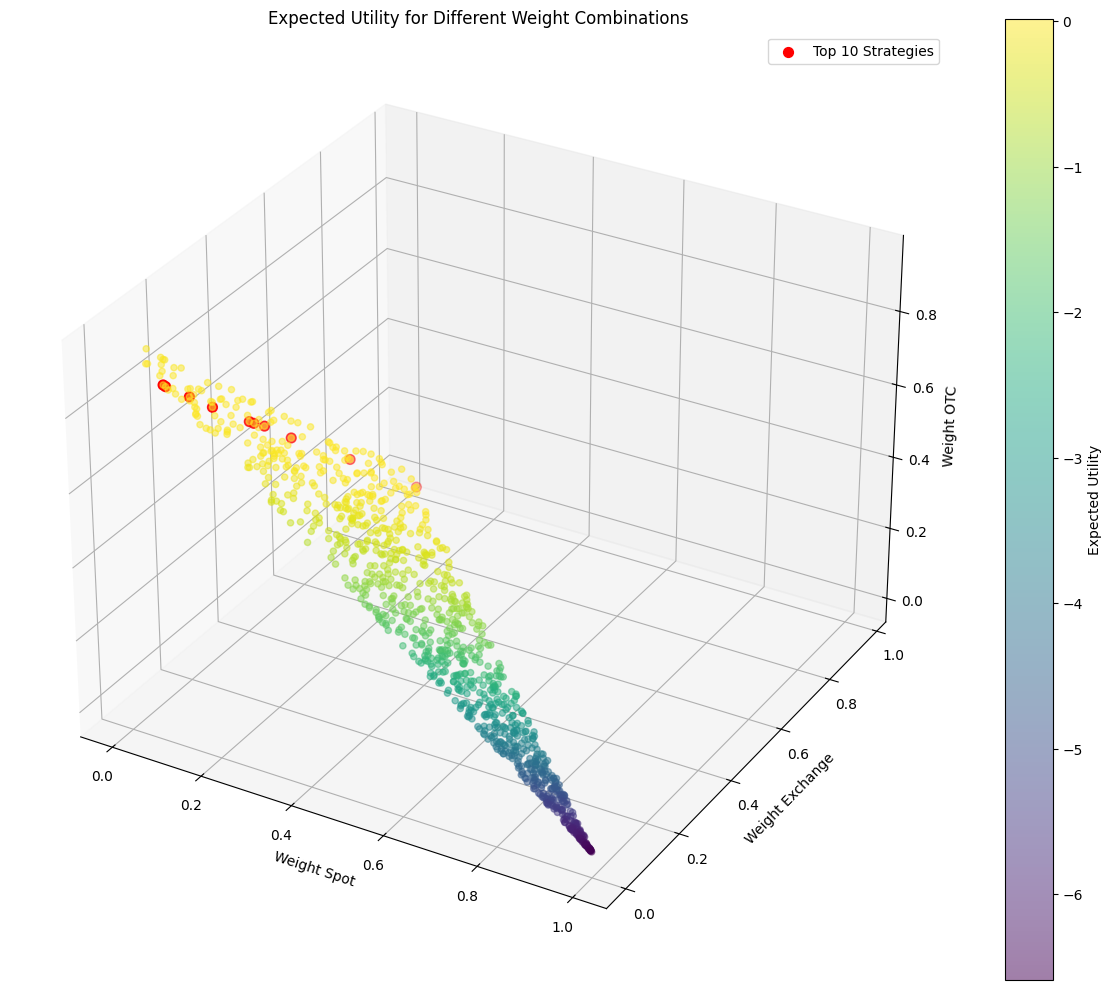

Top 10 Strategies:
 Weight Spot  Weight Exchange  Weight OTC  Expected Utility
    0.096064         0.083866    0.820069          0.012500
    0.078413         0.354648    0.566939          0.012492
    0.044954         0.953285    0.001761          0.012453
    0.056491         0.687487    0.256021          0.012452
    0.098371         0.006077    0.895551          0.012450
    0.076656         0.448292    0.475052          0.012425
    0.085630         0.308282    0.606087          0.012406
    0.086736         0.291482    0.621782          0.012402
    0.095609         0.157945    0.746446          0.012360
    0.096669         0.001099    0.902232          0.012336


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D

# Load spot price data
df = pd.read_excel(r"spot_prices_simulation_example.xlsx")
spot_values = df.iloc[:, 1].values[:]  # Extract spot values from the second column
spot_val = df.iloc[:, 1].values[1:]  # Exclude the first value

#PnL_Spot_T
PnL_Spot_T = sum((3.4 / 1000) * (-9 + spot) for spot in spot_val)
# Note: The spot price model follows the one factor model of Schwartz (1997)

# Function to calculate forward prices
def calculate_forward_prices(S, T_values, kappa, alpha, sigma):
    forward_prices = {}
    for T in T_values:
        term1 = np.exp(-kappa * T) * np.log(S)
        term2 = (1 - np.exp(-kappa * T)) * alpha
        term3 = (sigma**2 * (1 - np.exp(-2 * kappa * T))) / (4 * kappa)
        forward_price = np.exp(term1 + term2 + term3)
        forward_prices[T] = forward_price
    return forward_prices

# Set parameters for forward price calculation
S = 10  # Spot price
kappa, alpha, sigma = 0.15, 2.019899167, 0.2945  # Model parameters
yannual, T = 0.05, 36  # Annual yield and time to maturity
T_values = list(range(1, T+1))  # Time to maturity values

# Calculate OTC forward prices and PnL_exchange_T
forward_prices_OTC = calculate_forward_prices(S, T_values, kappa, alpha, sigma)
PnL_exchange_T = sum((3.4 / 1000) * (-9 + forward_prices_OTC[T]) for T in T_values)

# forward_matrix
forward_matrix = {i: calculate_forward_prices(spot_values[i], T_values, kappa, alpha, sigma) for i in range(len(spot_values))}


## Calculate PnL_OTC

## Functions for PnL OTC
# counterparty weights matrix - no default state
def cp_weight_no_default_matrix(
    number_of_months: int, cp_defaults: np.ndarray
) -> np.ndarray:
    """Create a matrix of counterparty weights for multiple counterparties.

    :param number_of_months: Number of simulated months
    :param cp_defaults: Array of default indicators for all counterparties

    :returns cp_weights_matrix: Matrix of counterparty weights
    """
    num_counterparties = cp_defaults.shape[0]
    cp_weights_matrix = np.zeros((num_counterparties, number_of_months, number_of_months))

    for i in range(num_counterparties):
        if i == 0:
            prior_default = None
        else:
            prior_default = cp_defaults[i-1]
        
        cp_weights = np.zeros((number_of_months, number_of_months))
        
        if prior_default is None:
            for forward_month in range(number_of_months):
                cp_weights[0, forward_month] = 1 * (1 - cp_defaults[i, forward_month])
        else:
            default_dates = np.nonzero(prior_default)[0]
            if default_dates.size > 0:
                default_date = default_dates[0]
                affected_forwards = default_dates[1:]
                cp_weights[default_date, : len(affected_forwards)] = 1 * (1 - cp_defaults[i, affected_forwards])
        
        cp_weights_matrix[i] = cp_weights

    return cp_weights_matrix

# PnL_OTC_no_default
def PnL_OTC_no_default(forward_matrix, cp_weights_matrix,N,T):
    total_sum = 0
    
    for t in range(1, T+1):  # t goes from 1 to 36
        for n in range(1, N + 1):  # n goes from 1 to N
            for i in range(1, T - t + 2):  # i goes from 1 to 36-t+1
                total_sum += (-9 + forward_matrix[t-1][i]) * cp_weights_matrix[n-1,t-1,i-1]
    
    return total_sum*3.6/1000

# counterparty weights matrix - default state - spot substitution
def cp_weight_spot_substitution(number_of_months: int, cp_default: np.ndarray) -> np.ndarray:
    """Counterparty weight per time step in default state used to compute PnL effect due to spot hedging of in-delivery
    position.

    :param number_of_months: Number of simulated months
    :param cp_default: Default indicator of counterparty with 1 if counterparty defaulted else 0.

    :returns cp_weights: Counterparty weight for given simulated time step and and forward month.
    """
    cp_weights = np.zeros(number_of_months)
    default_date = np.nonzero(cp_default)[0]
    if default_date.size > 0:
        default_date = default_date[0]
        cp_weights[default_date] = 1

    return cp_weights

# PnL_OTC_spot_substitution
def PnL_OTC_spot_substitution(cp_spot_weights_matrix,N,T):
    total_sum = 0
    
    for t in range(1, T+1):  # t goes from 1 to 36
        for n in range(1, N + 1):  # n goes from 1 to N
            total_sum += (-9 + spot_values[t]) * cp_spot_weights_matrix[n-1,t-1]
    
    return total_sum*3.4/1000

# counterparty weights - default state - rehedging - matrix
def cp_weight_default_rehedging(
    number_of_months: int, cp_current_default: np.ndarray, cp_prior_default: np.ndarray
) -> np.ndarray:
    """Counterparty weight per time step and forward month in default state used to compute Pnl effect due
    to re-hedging.

    :param number_of_months: Number of simulated months
    :param cp_current_default: Default indicator of current counterparty with 1 if counterparty defaulted else 0.
    :param cp_prior_default: Default indicator of prior counterparty with 1 if counterparty defaulted else 0.

    :returns cp_weights: Counterparty weight for given simulated time step and and forward month.
    """

    cp_weights = np.zeros((number_of_months, number_of_months))
    # find defaulted months of counterparty
    if cp_prior_default is None:
        # first counterparty locked in forward curve on hedge inception date
        cp_forward_curve_date = 0
        non_defaulted_forwards = np.where(cp_current_default == 0)[0]
    else:
        # otherwise get date of forward curve from prior default
        cp_forward_curve_date = np.nonzero(cp_prior_default)[0][0]
        # delta no-defaulted forwards
        non_defaulted_forwards = np.setdiff1d(np.where(cp_current_default == 0)[0], np.where(cp_prior_default == 0)[0])

    default_dates = np.nonzero(cp_current_default)[0]
    if default_dates.size > 0:
        cp_weights[cp_forward_curve_date, default_dates - cp_forward_curve_date] = 1
        for affected_forward in range(0, len(non_defaulted_forwards)):
            cp_weights[cp_forward_curve_date + affected_forward + 1, :] = np.roll(
                cp_weights[cp_forward_curve_date, :], shift=-(affected_forward + 1)
            )

    return cp_weights

# PnL_OTC_rehedging-----------------------------------------------
def PnL_OTC_rehedging(forward_matrix, cp_rehedging_matrix, N, T):
    total_sum = 0
    
    for t in range(1, T+1):  # t goes from 1 to T
        for n in range(1, N+1):  # n goes from 0 to N-1
            I = 3 - t + 1
            for i in range(1, I+1):  # i goes from 1 to T-t+1
                # Ensure proper indexing for forward_matrix
                if i == 1:
                  forward_diff = spot_values[t] - forward_matrix[t-1][i]
                else:
                  forward_diff = forward_matrix[t][i-1] - forward_matrix[t-1][i]
                total_sum += min(forward_diff, 0) * cp_rehedging_matrix[n-1, t-1, i-1]
    
    return total_sum * 3.4 / 1000


#Parameters
N = 2 # Number of counter parties


# assumptions:
# OTC trading: trade all with one counterparty, if the counterparty defaults, move to next counterparty
# Considering 2 counter parties
# Scenario: cp 1 defaults at time period 2
cp1_default = np.ones(36)
cp1_default[0] = 0
cp2_default = np.zeros(36)

# cp_weights_matrix
cp_defaults = np.vstack([cp1_default, cp2_default])
cp_weights_matrix = cp_weight_no_default_matrix(T, cp_defaults)
#print(f"cp_weights_matrix: {cp_weights_matrix}")

# PnL_OTC_no_default
PnL_OTC_no_default = PnL_OTC_no_default(forward_matrix, cp_weights_matrix, N,T)
#print(f"PnL_OTC_no_default: {PnL_OTC_no_default}")

# counterparty weights - default state - spot substitution
cp1_spot_substitution = cp_weight_spot_substitution(T, cp1_default)
cp2_spot_substitution = cp_weight_spot_substitution(T, cp2_default)

# Create a matrix containing both cp1_spot_substitution and cp2_spot_substitution
cp_spot_substitution_matrix = np.array((cp1_spot_substitution, cp2_spot_substitution))

#PnL_OTC_spot_substitution
PnL_OTC_spot_substitution = PnL_OTC_spot_substitution(cp_spot_substitution_matrix, N,T)
#print(f"PnL_OTC_spot_substitution: {PnL_OTC_spot_substitution}")

# counterparty weights - default state - rehedging
cp1_rehedging = cp_weight_default_rehedging(T, cp1_default, None)
cp2_rehedging = cp_weight_default_rehedging(T, cp2_default, cp1_default)

# Create a matrix containing both cp1_spot_substitution and cp2_spot_substitution
cp_rehedging_matrix = np.array((cp1_rehedging, cp2_rehedging))

# PnL_OTC_rehedging
PnL_OTC_rehedging = PnL_OTC_rehedging(forward_matrix, cp_rehedging_matrix, N, T)
#print(f"PnL_OTC_rehedging: {PnL_OTC_rehedging}")

# PnL_OTC_default
PnL_OTC_default = PnL_OTC_rehedging + PnL_OTC_spot_substitution

# PnL_OTC
PnL_OTC_T = PnL_OTC_default + PnL_OTC_no_default


# Function to calculate cash balance
def calculate_cash_balance(yannual, forward_matrix, T, spot_values):
    cashbalance = 0
    for t in range(1, T+1):
        I = 36 - t + 1
        for i in range(1, I+1):
            if i == 1:
                forward_diff = spot_values[t] - forward_matrix[t-1][i]
            else:
                forward_diff = forward_matrix[t][i-1] - forward_matrix[t-1][i]
            cashbalance += (np.exp(yannual/12) - 1) * max(forward_diff, 0)
    return cashbalance * 3.4 / 1000

# Calculate cash balance
cashbalance_T = calculate_cash_balance(yannual, forward_matrix, T, spot_values)

# Function to generate random weight values
def generate_random_values():
    while True:
        x = random.uniform(0, 1)
        y = random.uniform(0, 1 - x)
        z = 1 - x - y
        if 0 <= x <= 1 and 0 <= y <= 1 and 0 <= z <= 1:
            break
    return x, y, z

# Function to calculate total PnL
def calculate_pnl_total(weight_spot, weight_exchange, weight_OTC):
    return (weight_spot * PnL_Spot_T) + (weight_exchange * (PnL_exchange_T - cashbalance_T)) + (weight_OTC * PnL_OTC_T)

# Utility function
def utility_function(PnL_total, gamma=20):
    expected_pnl_total = np.mean(PnL_total)
    variance_pnl_total = np.var(PnL_total)
    expected_squared_pnl_total = np.mean(PnL_total ** 2)
    return expected_pnl_total - gamma * (variance_pnl_total + expected_squared_pnl_total)

# Perform Monte Carlo simulations
num_simulations = 1000
weights_spot, weights_exchange, weights_OTC, expected_utilities = [], [], [], []

for _ in range(num_simulations):
    weight_spot, weight_exchange, weight_OTC = generate_random_values()
    weights_spot.append(weight_spot)
    weights_exchange.append(weight_exchange)
    weights_OTC.append(weight_OTC)
    PnL_total = calculate_pnl_total(weight_spot, weight_exchange, weight_OTC)
    expected_utility = utility_function(PnL_total, gamma=20)
    expected_utilities.append(expected_utility)

# Create DataFrame with simulation results
results_df = pd.DataFrame({
    'Weight Spot': weights_spot,
    'Weight Exchange': weights_exchange,
    'Weight OTC': weights_OTC,
    'Expected Utility': expected_utilities
})

# Get top 10 strategies
top_10 = results_df.sort_values('Expected Utility', ascending=False).head(10)

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Highlight top 10 strategies
ax.scatter(top_10['Weight Spot'], top_10['Weight Exchange'], top_10['Weight OTC'], 
           c='red', s=50, label='Top 10 Strategies')

# Plot all strategies
scatter = ax.scatter(weights_spot, weights_exchange, weights_OTC, c=expected_utilities, cmap='viridis', alpha=0.5)

# Set labels and title
ax.set_xlabel('Weight Spot')
ax.set_ylabel('Weight Exchange')
ax.set_zlabel('Weight OTC')
ax.set_title('Expected Utility for Different Weight Combinations')

# Add color bar and legend
cbar = fig.colorbar(scatter)
cbar.set_label('Expected Utility')
ax.legend()

plt.tight_layout()
plt.show()

# Print top 10 strategies
print("Top 10 Strategies:")
print(top_10.to_string(index=False))

Plot of forward prices and spot prices at time 0

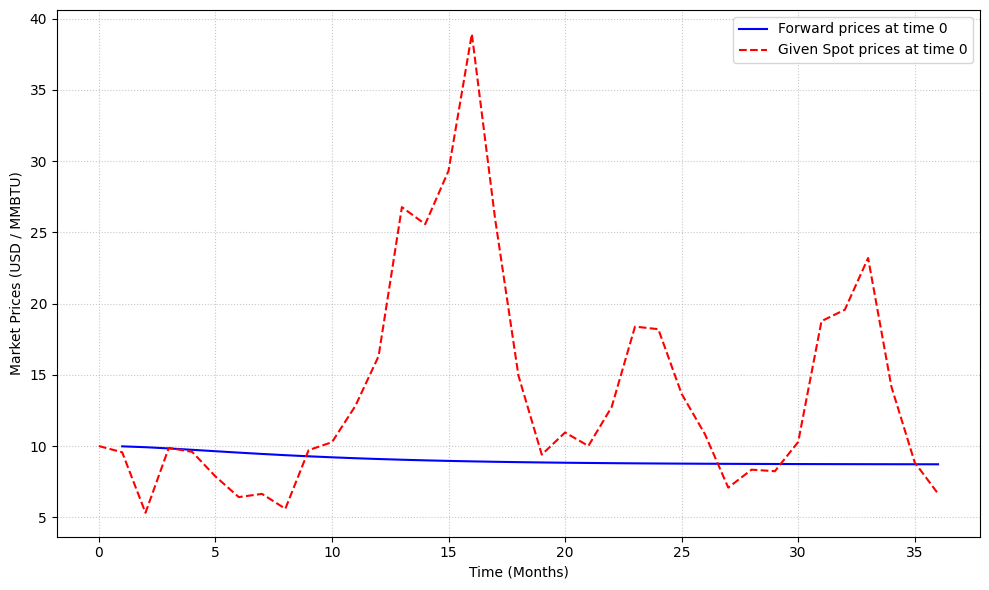

In [2]:
# Calculate forward prices using the previously defined function
forward_prices = calculate_forward_prices(S, T_values, kappa, alpha, sigma)

# Extract keys (T values) and values (Forward prices) from the dictionary
T_values = list(forward_prices.keys())
forward_price_values = list(forward_prices.values())

# Create a new figure with specified size
plt.figure(figsize=(10, 6))

# Plot forward prices
plt.plot(T_values, forward_price_values, linestyle='-', color='b', label='Forward prices at time 0')

# Plot spot prices from the dataframe
plt.plot(df['t'], df['spot'], linestyle='--', color='r', label='Given Spot prices at time 0')


plt.xlabel('Time (Months)')
plt.ylabel('Market Prices (USD / MMBTU)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()